# ICU Mortality Prediction using Machine Learning
## A Complete Tutorial with MIMIC-III Data and Random Forest Classification

### 🎯 Learning Objectives
By the end of this tutorial, you will be able to:
1. **Load and explore** MIMIC-III clinical database
2. **Engineer features** from electronic health records (EHR)
3. **Build a Random Forest classifier** for mortality prediction
4. **Evaluate model performance** using clinical metrics
5. **Interpret feature importance** for healthcare insights

### 📊 Dataset Overview
- **MIMIC-III**: Medical Information Mart for Intensive Care III
- **Source**: Beth Israel Deaconess Medical Center
- **Content**: De-identified health data from ICU patients
- **Goal**: Predict hospital mortality using patient characteristics

### 🔬 Methodology
- **Algorithm**: Random Forest (interpretable ensemble method)
- **Features**: Demographics, admission details, ICU length of stay
- **Evaluation**: AUC, confusion matrix, feature importance
- **Clinical Focus**: Actionable insights for healthcare providers

---

## 📚 Step 1: Import Required Libraries

We'll import all the necessary libraries for our machine learning pipeline:
- **Data manipulation**: pandas, numpy
- **Visualization**: matplotlib, seaborn
- **Machine Learning**: scikit-learn components
- **Preprocessing**: StandardScaler, LabelEncoder, SimpleImputer

In [15]:
# Core data manipulation libraries
import pandas as pd  # For data loading and manipulation
import numpy as np   # For numerical operations

# Visualization libraries
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns           # Statistical visualizations

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Data preprocessing
from sklearn.model_selection import train_test_split           # Data splitting
from sklearn.impute import SimpleImputer                       # Handle missing values

# Machine Learning - Model and Evaluation
from sklearn.ensemble import RandomForestClassifier            # Our main algorithm
from sklearn.metrics import (classification_report,           # Detailed performance metrics
                           roc_auc_score,                     # Area Under Curve
                           confusion_matrix,                  # Classification matrix
                           roc_curve)                         # ROC curve data

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All libraries imported successfully!")
print("📊 Ready to start the ICU mortality prediction tutorial")

✅ All libraries imported successfully!
📊 Ready to start the ICU mortality prediction tutorial


## 📂 Step 2: Load MIMIC-III Data

### Understanding MIMIC-III Tables:
- **PATIENTS.csv**: Patient demographics (gender, date of birth)
- **ADMISSIONS.csv**: Hospital admission details (admission type, insurance, mortality)
- **ICUSTAYS.csv**: ICU-specific information (length of stay, care units)

### Key Learning Point:
Always start by exploring your data structure - understanding column names and data types is crucial for healthcare ML projects.

In [16]:
# 🔍 STEP 2.1: Define data path and load MIMIC-III tables
# Note: Adjust this path based on your local setup
data_path = '../../mimic-iii-clinical-database-demo-1.4/'

# Load the three core tables we'll use for mortality prediction
print("📥 Loading MIMIC-III data tables...")

# PATIENTS: Contains patient demographics and basic information
patients = pd.read_csv(data_path + 'PATIENTS.csv')

# ADMISSIONS: Contains hospital admission details and outcomes
admissions = pd.read_csv(data_path + 'ADMISSIONS.csv')

# ICUSTAYS: Contains ICU-specific information
icustays = pd.read_csv(data_path + 'ICUSTAYS.csv')

# 🔍 STEP 2.2: Explore data structure
# Understanding column names is crucial - MIMIC-III uses lowercase naming
print("\n📋 Exploring data structure:")
print("Column names in admissions:")
print(list(admissions.columns))
print("\nColumn names in patients:")
print(list(patients.columns))
print("\nColumn names in icustays:")
print(list(icustays.columns))

# 📊 STEP 2.3: Display basic dataset information
print(f"\n📈 Dataset Overview:")
print(f"👥 Patients: {len(patients):,} unique patients")
print(f"🏥 Admissions: {len(admissions):,} hospital admissions")
print(f"🏥 ICU Stays: {len(icustays):,} ICU admissions")

print("\n✅ Data loading completed successfully!")

📥 Loading MIMIC-III data tables...

📋 Exploring data structure:
Column names in admissions:
['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data']

Column names in patients:
['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag']

Column names in icustays:
['row_id', 'subject_id', 'hadm_id', 'icustay_id', 'dbsource', 'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime', 'los']

📈 Dataset Overview:
👥 Patients: 100 unique patients
🏥 Admissions: 129 hospital admissions
🏥 ICU Stays: 136 ICU admissions

✅ Data loading completed successfully!


Hospital mortality rate: 31.0%


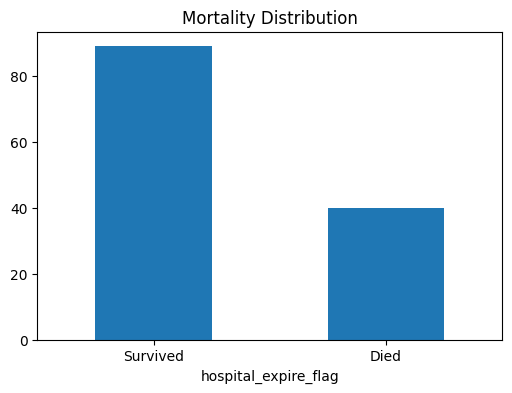

In [17]:
# Check mortality rate with correct column name
mortality_rate = admissions['hospital_expire_flag'].mean()
print(f"Hospital mortality rate: {mortality_rate:.1%}")

# Quick visualization
plt.figure(figsize=(6, 4))
admissions['hospital_expire_flag'].value_counts().plot(kind='bar')
plt.title('Mortality Distribution')
plt.xticks([0, 1], ['Survived', 'Died'], rotation=0)
plt.show()

In [18]:
# Create simple features
def create_features():
    # Start with admissions
    features = admissions[['hadm_id', 'subject_id', 'hospital_expire_flag', 'admission_type', 'insurance']].copy()
    
    # Add patient info
    patient_info = patients[['subject_id', 'gender']].copy()
    features = features.merge(patient_info, on='subject_id')
    
    # Add ICU length of stay
    icu_los = icustays.groupby('hadm_id')['los'].sum().reset_index()
    features = features.merge(icu_los, on='hadm_id', how='left')
    features['los'] = features['los'].fillna(0)
    
    return features

df = create_features()
print(f"Created dataset with {len(df)} rows and {len(df.columns)} columns")
print(f"Columns: {list(df.columns)}")

Created dataset with 129 rows and 7 columns
Columns: ['hadm_id', 'subject_id', 'hospital_expire_flag', 'admission_type', 'insurance', 'gender', 'los']


In [19]:
# Simple preprocessing and modeling
# Encode categorical variables
le_gender = LabelEncoder()
df['gender_encoded'] = le_gender.fit_transform(df['gender'])

le_admission = LabelEncoder()
df['admission_encoded'] = le_admission.fit_transform(df['admission_type'])

le_insurance = LabelEncoder()
df['insurance_encoded'] = le_insurance.fit_transform(df['insurance'])

# Select features
feature_cols = ['gender_encoded', 'admission_encoded', 'insurance_encoded', 'los']
X = df[feature_cols]
y = df['hospital_expire_flag']

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Feature matrix shape: (129, 4)
Target distribution: {0: 89, 1: 40}


In [20]:
# Train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_imp, y_train)

# Predictions
y_pred = rf.predict(X_test_imp)
y_pred_proba = rf.predict_proba(X_test_imp)[:, 1]

# Results
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC Score: {auc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

AUC Score: 0.618

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.50      0.38      0.43         8

    accuracy                           0.69        26
   macro avg       0.62      0.60      0.61        26
weighted avg       0.67      0.69      0.68        26



Feature Importance:
             feature  importance
3                los    0.835323
2  insurance_encoded    0.073540
0     gender_encoded    0.047004
1  admission_encoded    0.044134


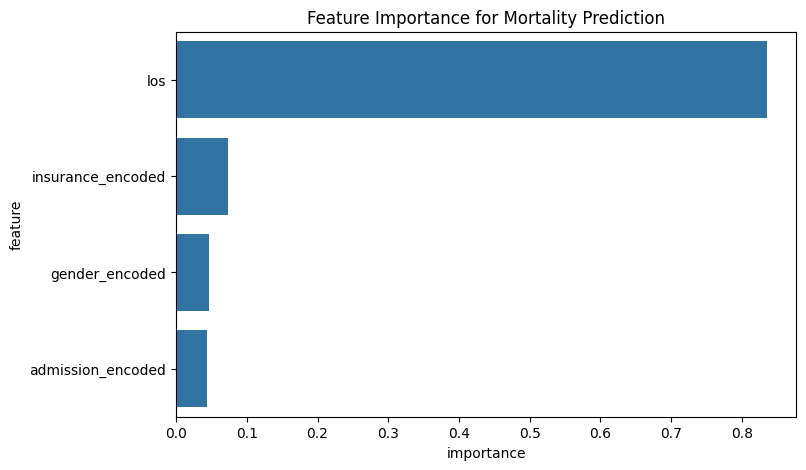

In [21]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(importance_df)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='importance', y='feature')
plt.title('Feature Importance for Mortality Prediction')
plt.show()